<a href="https://colab.research.google.com/github/mdehling/neural-style-transfer/blob/main/Gatys_Texture_Synthesis_and_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this notebook I will reproduce the results of the seminal works of Gatys et al on texture synthesis (_Texture Synthesis Using Convolutional Neural Networks_ [1]) and neural style transfer (_A Neural Algorithm of Artistic Style_ [2]), and I will go through some of the many variations and improvements of the original algorithm suggested by Gatys himself aswell as other authors.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

## Utility Functions
Simple functions to load images as tensors and display them in the notebook.

In [ ]:
def load_image(file, target_size=(256,256)):
    """
    Loads image from file and returns it as tensor of size
    (1,height,width,channels).  Does *not* keep aspect ratio.
    """
    # TF 2.9 adds a keep_aspect_ratio option that would be nice to use.
    image = tf.keras.utils.load_img(file, target_size=target_size,
                                    interpolation='bicubic')

    image_tensor = tf.keras.utils.img_to_array(image, dtype="float32")
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    return image_tensor

def show_image(image_tensor):
    """
    Takes 4-D image_tensor of size (1,height,width,channels) and displays it in
    Jupyter notebook.
    """
    display(tf.keras.utils.array_to_img(image_tensor[0]))

# Texture Synthesis
The idea behind texture synthesis is to generate an image with similar texture/style to a given sample.  It can be viewed as a preliminary step to neural style transfer.  The main idea of Gatys' article [1] is that texture/style can be represented by the correlations between feature maps in several layers of a CNN trained for image recognition.  In the original work, the correlations are measured by the Gram matrix of the filter responses to certain layers in a VGG19 network trained on the ImageNet dataset.

## Iterative Image Generation
Gatys proposed an interative process where, starting from random noise, at each step the gradients for a loss function are computed and the current image is modified to reduce the loss using standard optimization techniques (SGD, Adam, ...)  The following is a simple implementation of the general process taking loss functions and optimizer as inputs and automatically computing gradients using TensorFlow GradientTape class.

In [ ]:
class ImageGenerator:
    """
    Iterative Image Generation.

    Minimizes the total loss computed by the provided loss functions using the
    provided optimizer.
    """

    def __init__(self, loss_functions, optimizer,
                 initial=None, shape=(256,256,3)):
        
        self.loss_functions = loss_functions
        self.optimizer = optimizer

        # Initialize randomly or use initial image provided
        if initial is None:
            self.image = tf.random.uniform(shape, 0.0, 255.0)
            self.image = tf.expand_dims(self.image, axis=0)
        else:
            self.image = initial

        self.image = tf.Variable(self.image)

        self.images = [ tf.keras.utils.array_to_img(self.image[0]) ]
        self.losses = []

    def __call__(self, epochs=1, steps_per_epoch=100, show=True):
        """
        Compute epochs * steps_per_epoch iterations of loss minimization using
        the provided optimzer.
        """
        for n in range(epochs):
            for m in range(steps_per_epoch):

                with tf.GradientTape() as tape:
                    total_loss = tf.add_n([
                        loss_fn(self.image) for loss_fn in self.loss_functions
                    ])

                self.losses.append(total_loss)
                gradient = tape.gradient(total_loss, self.image)

                self.optimizer.apply_gradients([(gradient, self.image)])
                self.image.assign(tf.clip_by_value(self.image, 0.0, 255.0))

            # Save the result at the end of each epoch for visualization
            self.images.append(tf.keras.utils.array_to_img(self.image[0]))

        if show is True:
            self.show_image()

    def show_image(self):
        show_image(self.image)

## VGG19 Texture/Style Model
The following model simply returns the selected layer outputs from a VGG19 model pre-trained on the ImageNet dataset.

In [ ]:
class VGG19_Style(tf.keras.Model):
    """
    VGG19 Style Model.

    Based on a VGG19 model pre-trained on the ImageNet dataset, this model
    returns the filter activations at the lower levels of the 5 blocks making up
    the VGG19 model.  The outputs at these layers form a good representation
    of the style of an image.
    """

    def __init__(self, depth=5):
        """Create VGG19 style model."""
        base_model = tf.keras.applications.vgg19.VGG19(include_top=False,
                                                       weights='imagenet')
        base_model.trainable = False

        style_layers = [
            "block1_conv1",
            "block2_conv1",
            "block3_conv1",
            "block4_conv1",
            "block5_conv1"
        ]

        outputs = [ base_model.get_layer(name).output
                    for name in style_layers[:depth] ]

        super().__init__(inputs=base_model.input, outputs=outputs)

    def call(self, inputs, **kwargs):
        """
        Calls the model on inputs.
        
        Required preprocessing is done inside the model.  Expected inputs are of
        shape (batches,height,width,channels=3) and take values in 0.0 .. 255.0.
        """
        inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        
        return super().call(inputs, **kwargs)

Instantiate the style model for use below.  This will automatically download and load the pre-trained weights for the VGG19 base model.

In [ ]:
style_model = VGG19_Style()

80150528/80134624 [==============================] - 1s 0us/step


## Style Loss
Denote by $F^l \in \mathbf{R}^{N_l\times M_l}$ the feature vector (output) produced by layer $l$ of the CNN, where $N_l$ is the number of filters in layer $l$ and $M_l$ the size of the output in number of pixels.  The averaged Gram matrix $G^l \in \mathbf{R}^{N_l\times N_l}$ of $F^l$ is defined by
$$ G^l_{rs} = \frac{1}{M_l^2} \big\langle F^l_{r:} \big| F^l_{s:} \big\rangle = \frac{1}{M_l^2} \sum_i F^l_{ri} F^l_{si} \quad. $$

Note that I have followed the convention to divide by $M_l^2$ from Gatys' work.  Unfortunately this means that the magnitude of the loss defined below depends on the size of the image.  Dividing by $M_l$ instead would avoid this issue.

In [ ]:
def avg_gram_tensor(Fl):
    """Computes the averaged Gram tensor for a layer's feature tensor Fl."""
    _, height, width, _ = tf.shape(Fl)
    Ml = tf.cast(width * height, tf.float32)

    # In the formula above the cordinates of the image are flattened into one
    # dimension; here we sum over i and j (height and width) separately.
    Gl = tf.linalg.einsum('bijr,bijs->brs', Fl, Fl) / Ml**2

    return Gl

Let $\hat{G}^l$ be the averaged Gram tensor for the provided style image and $G^l$ that for the generated image.  The layer $l$ component of the style loss is
$$ \mathcal{L}_S^l = \frac{1}{4 N_l^2} \sum_{r,s} \Big( G^l_{rs} - \hat{G}^l_{rs} \Big)^2 $$
and the overall style loss $\mathcal{L}_S$ is defined as the mean of these layer components.

In [ ]:
class StyleLoss:

    def __init__(self, style_image, style_model, weight=1.0):
        """
        Initialize with style sample and model used to compute style loss.
        """
        self.style_image = style_image
        self.style_model = style_model
        self.weight = weight

        self.image_targets = [
            avg_gram_tensor(layer_output)
            for layer_output in self.style_model(self.style_image)
        ]

    def __call__(self, image):
        """
        Calculate the style loss for the image parameter given the previously
        provided style sample.
        """
        image_features = [
            avg_gram_tensor(layer_output)
            for layer_output in self.style_model(image)
        ]

        # Compute layer components of style loss.
        layer_losses = [
            tf.reduce_mean(tf.square(feature - target)) / 4
            for feature, target in zip(image_features, self.image_targets)
        ]
        
        # Calculate overall style loss and multiply by given weight.
        return self.weight * tf.add_n(layer_losses) / len(layer_losses)

## Example of Texture Generation
This image of pebbles is the first example of a style sample I will consider.

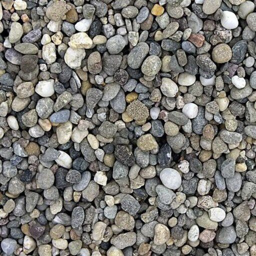

In [ ]:
!wget -q https://github.com/mdehling/neural-style-transfer/raw/main/img/pebbles.jpeg
pebbles_image = load_image("pebbles.jpeg", target_size=(256,256))
show_image(pebbles_image)

I'll use good old stochastic gradient descent as my optimizer and plot the loss for a range of learning rates to determine a reasonable value to use.

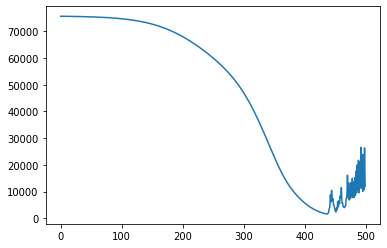

In [ ]:
optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(1e-2, 100, 10.0)
)
imgen = ImageGenerator([StyleLoss(pebbles_image, style_model)], optimizer)
# Run for 5 epochs, i.e., for learning rates 1e-2 up to 1e+3.  The final result
# will be chaos, so disregard it.
imgen(5, show=False)
plt.plot(imgen.losses)

It looks like around 400 steps the learning rate is close to optimal &mdash; that corresponds to about 1e+2.  So run this again with that learning rate to see what the result looks like.

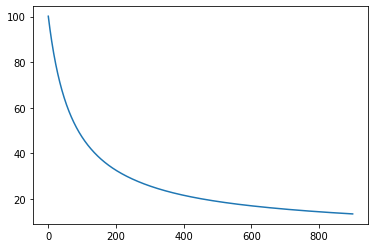

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e+2, momentum=0.9)
imgen = ImageGenerator([StyleLoss(pebbles_image, style_model)], optimizer)
imgen(epochs=10, show=False)
plt.plot(imgen.losses[100:])

The loss function looks good, so let's have a look at the resulting image:

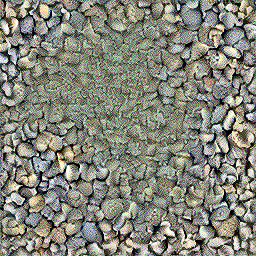

In [ ]:
imgen.show_image()

Not terrible, also not great.  The pebbles structure is clear in some parts, less so in others.  In addition the image is very grainy.  I'll run the image generator for another 90 epochs (for a total of 100) to see if the results improve.

In [ ]:
imgen(epochs=90, show=False)
pebbles100 = imgen.images[100]

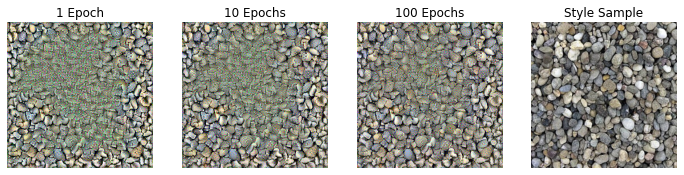

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))

ax[0].imshow(tf.keras.utils.array_to_img(imgen.images[1]))
ax[0].set_title("1 Epoch")
ax[1].imshow(tf.keras.utils.array_to_img(imgen.images[10]))
ax[1].set_title("10 Epochs")
ax[2].imshow(tf.keras.utils.array_to_img(imgen.images[100]))
ax[2].set_title("100 Epochs")
ax[3].imshow(tf.keras.utils.array_to_img(pebbles_image[0]))
ax[3].set_title("Style Sample")

for axi in ax.ravel():
    axi.set_axis_off()

There are some slight improvements at least.  The style loss is still decreasing, albeit slowly:

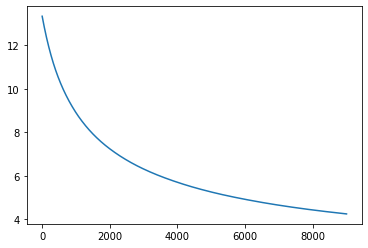

In [ ]:
plt.plot(imgen.losses[-90*100:])

I'll let this run for a total of 1000 epochs and look at the results and the loss function.  Note that this takes some time to complete!

In [ ]:
# Runtime ca 1h on Colab!
imgen(epochs=900, show=False)
pebbles1000 = imgen.images[1000]

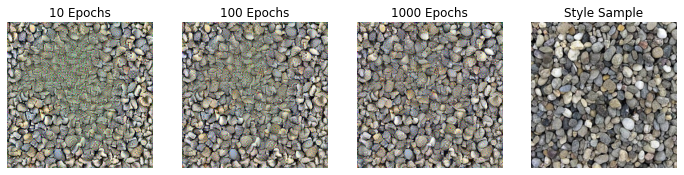

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))

ax[0].imshow(tf.keras.utils.array_to_img(imgen.images[10]))
ax[0].set_title("10 Epochs")
ax[1].imshow(tf.keras.utils.array_to_img(imgen.images[100]))
ax[1].set_title("100 Epochs")
ax[2].imshow(tf.keras.utils.array_to_img(imgen.images[1000]))
ax[2].set_title("1000 Epochs")
ax[3].imshow(tf.keras.utils.array_to_img(pebbles_image[0]))
ax[3].set_title("Style Sample")

for axi in ax.ravel():
    axi.set_axis_off()

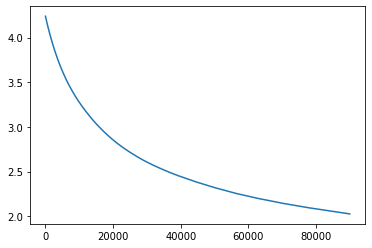

In [ ]:
plt.plot(imgen.losses[-900*100:])

The result is still getting better and better, both visually and based on the loss function.  Looking closely at the generated image after 1000 epochs, however, it is still pretty grainy/noisy.  We will see how to improve this in the next section.

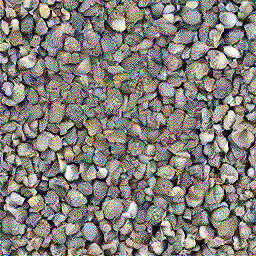

In [ ]:
imgen.show_image()

## Variation Loss
A common way to remove noise from the generated image is to introduce an additional term to the total loss function: the variation loss.  From the TensorFlow API documentation:

> The total variation is the sum of the absolute differences for neighboring pixel-values in the input images. This measures how much noise is in the images.

Explicitly, the (anisotropic) [total variation](https://en.wikipedia.org/wiki/Total_variation_denoising#2D_signal_images) of an image with pixels $X_{i,j}$ is defined as

$$ V(X) = \sum_{i,j} |X_{i+1,j}-X_{i,j}| + |X_{i,j+1}-X_{i,j}| \quad. $$

This loss function is built in to TensorFlow, we just need a little wrapper class to use it.

In [ ]:
class VariationLoss:
    """Anisotropic total variation loss."""

    def __init__(self, weight=1e-3):
        self.weight = weight

    def __call__(self, image):
        return self.weight * tf.image.total_variation(image[0])

The following will create another pebbles style reproduction, this time with variation loss.  Scroll down for a comparison of the results with and without V-loss.

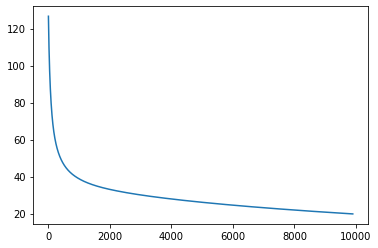

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e+2, momentum=0.9)
imgen = ImageGenerator([
    StyleLoss(pebbles_image, style_model),
    VariationLoss(weight=1e-6)
    ], optimizer)
imgen(epochs=100, show=False)
pebbles100v = imgen.images[100]
plt.plot(imgen.losses[100:])

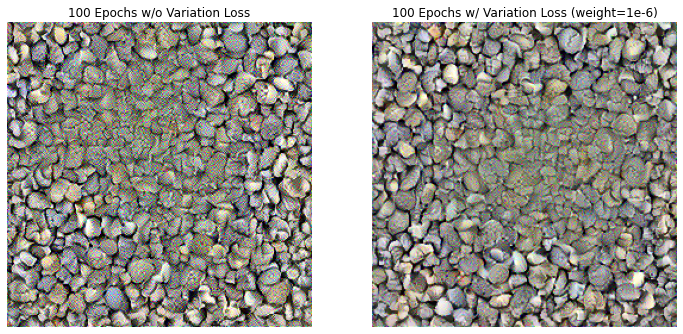

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].imshow(tf.keras.utils.array_to_img(pebbles100))
ax[0].set_title("100 Epochs w/o Variation Loss")
ax[1].imshow(tf.keras.utils.array_to_img(pebbles100v))
ax[1].set_title("100 Epochs w/ Variation Loss (weight=1e-6)")

for axi in ax.ravel():
    axi.set_axis_off()

In [ ]:
# Runtime ca 1h on Colab!
imgen(epochs=900, show=False)
pebbles1000v = imgen.images[1000]

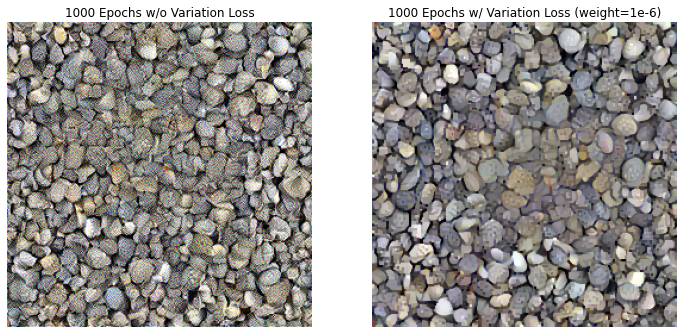

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].imshow(tf.keras.utils.array_to_img(pebbles1000))
ax[0].set_title("1000 Epochs w/o Variation Loss")
ax[1].imshow(tf.keras.utils.array_to_img(pebbles1000v))
ax[1].set_title("1000 Epochs w/ Variation Loss (weight=1e-6)")

for axi in ax.ravel():
    axi.set_axis_off()

The following example should show the effects of minimizing variation loss even more clearly.  Without variation loss, the evenly colored areas are prone to causing dithering in the generated image.

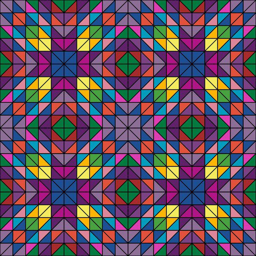

In [ ]:
!wget -q https://github.com/mdehling/neural-style-transfer/raw/main/img/triangles.jpeg
triangles_image = load_image("triangles.jpeg", target_size=(256,256))
show_image(triangles_image)

In [ ]:
# Runtime ca 30min on Colab!
optimizer = tf.keras.optimizers.Adam(0.1)
imgen = ImageGenerator([
    StyleLoss(triangles_image, style_model)
    ], optimizer)
imgen(epochs=200, show=False)
triangles200 = imgen.images[200]

optimizer = tf.keras.optimizers.Adam(0.1)
imgen = ImageGenerator([
    StyleLoss(triangles_image, style_model),
    VariationLoss(weight=1e-5)
    ], optimizer)
imgen(epochs=200, show=False)
triangles200v = imgen.images[200]

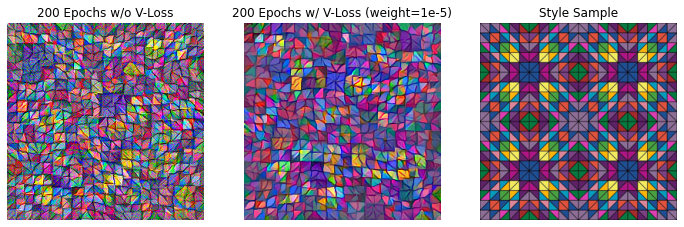

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].imshow(tf.keras.utils.array_to_img(triangles200))
ax[0].set_title("200 Epochs w/o V-Loss")
ax[1].imshow(tf.keras.utils.array_to_img(triangles200v))
ax[1].set_title("200 Epochs w/ V-Loss (weight=1e-5)")
ax[2].imshow(tf.keras.utils.array_to_img(triangles_image[0]))
ax[2].set_title("Style Sample")

for axi in ax.ravel():
    axi.set_axis_off()

Clearly, in this example, the use of variation loss leads to a major improvement in visual results.

## Example of Long-Range Structure
The Gram tensor measures correlation of filter activations locally but does not take long-range structure into account.  Consider the following example of a wall of evenly sized bricks showing clear horizontal and vertical lines.

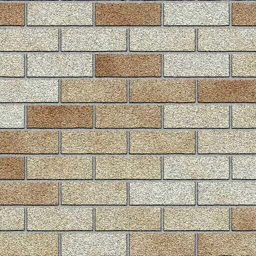

In [ ]:
!wget -q https://github.com/mdehling/neural-style-transfer/raw/main/img/wall.jpeg
wall_image = load_image("wall.jpeg", target_size=(256,256))
show_image(wall_image)

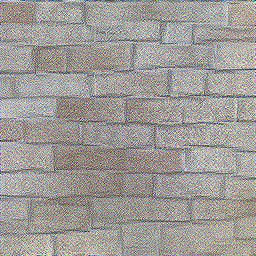

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.3)
imgen = ImageGenerator([StyleLoss(wall_image, style_model)], optimizer)
imgen(epochs=200)
wall200 = imgen.images[200]

Among other issues (such as the image noise), note that the generated image does _not_ capture the regularity of the style sample well.  The crosscorrelation loss introduced in the next section is one way of dealing with this.

## Crosscorrelation Loss
Crosscorrelation loss was proposed by Berger and Memisevic in their article _Incorporating Long-Range Consistency in CNN-Based Texture Generation_ [3].  They propose to add another loss term similar to the style loss which they call the crosscorrelation loss.  The way it takes long-range structure into account is by considering the correlation between filter responses in different locations of the image.

Denote by $T_{(\delta_x,\delta_y)}$ the translation operator.  Applying it to an image shifts it by $\delta_x$ pixels along the $x$-axis and by $\delta_y$ along the $y$-axis.  Now denote by $G^l_{(\delta_x,\delta_y)}$ the modified Gram tensor with components
$$ G^l_{(\delta_x,\delta_y),rs} = \frac{1}{M_l^2} \big\langle T_{(-\delta_x,-\delta_y)}(F^l_{r:}) \big| T_{(\delta_x,\delta_y)}(F^l_{s:}) \big\rangle \quad. $$
This tensor measures correlation between filter responses $(2\delta_x,2\delta_y)$ apart.

The layer $l$ component of the crosscorrelation loss for some $\delta$ is then defined as
$$ \mathcal{L}^l_{\text{cc},\delta} = \frac{1}{8N_l^2} \Big( \Big\Vert G^l_{(\delta,0)} - \hat{G}^l_{(\delta,0)} \Big\Vert^2 + \Big\Vert G^l_{(0,\delta)} - \hat{G}^l_{(0,\delta)} \Big\Vert^2 \Big) \quad, $$
and the overall crosscorrelation loss is simply the mean of the layer components.

(I have changed the normation factor from the original article so that for $\delta=0$ the crosscorrelation loss is the same as the style loss.)

To implement the above, I start by redefining the `avg_gram_tensor` function to allow arbitrary transformations to the left and right of the vector product.  By default these will be the identity transformation so that the function can still be used as before.

In [ ]:
def id(Fl):
    return Fl

def avg_gram_tensor(Fl, Tl=id, Tr=id):
    TlFl = Tl(Fl)
    TrFl = Tr(Fl)

    _, height, width, _ = tf.shape(TlFl)
    Ml = tf.cast(width*height, tf.float32)

    return tf.linalg.einsum('bijr,bijs->brs', TlFl, TrFl) / Ml**2

Now define the crosscorrelation loss.  This looks very similar to the style loss defined earlier, except that it takes a list of pairs of left and right transformations to be applied to the layer responses when calculating their (modified) Gram tensors.

In [ ]:
class CrosscorrelationLoss:

    def __init__(self, style_image, style_model, transformations, weight=1.0):
        self.style_image = style_image
        self.style_model = style_model
        self.transformations = transformations
        self.weight = weight

        self.image_targets = []
        for Tl, Tr in self.transformations:
            self.image_targets = [
                avg_gram_tensor(layer_output, Tl, Tr)
                for layer_output in self.style_model(self.style_image)
            ]

    def __call__(self, image):
        image_features = []
        for Tl, Tr in self.transformations:
            image_features = [
                avg_gram_tensor(layer_output, Tl, Tr)
                for layer_output in self.style_model(image)
            ]

        layer_losses = [
            tf.reduce_mean(tf.square(feature - target)) / 4
            for feature, target in zip(image_features, self.image_targets)
        ]
        
        return self.weight * tf.add_n(layer_losses) / len(layer_losses)

The following function returns the translation operator $T_{(\delta_x,\delta_y)}$ given a pair $(\delta_x,\delta_y)$.  This is implemented in the most naive way possible, simply by providing a smaller (by $\delta_x$, $\delta_y$) view of the tensor.

In [ ]:
def T_d(dx, dy):
    def T(Fl):
        _, height, width, _ = tf.shape(Fl)

        if dx < 0:
            x1 = 0;  x2 = width + dx
        else:
            x1 = dx; x2 = width

        if dy < 0:
            y1 = 0;  y2 = height + dy
        else:
            y1 = dy; y2 = height

        return Fl[:,y1:y2,x1:x2,:]

    return T

The code below will generate another style reproduction of the wall image, this time using crosscorrelation loss to take long-range structure into account.

In [ ]:
# Runtime ca 1:15h on Colab!
optimizer = tf.keras.optimizers.Adam(0.3)
imgen = ImageGenerator([
        StyleLoss(wall_image, style_model),
        CrosscorrelationLoss(wall_image, style_model,
            [ (T_d(-dx,-dy),T_d(dx,dy))
            for dx, dy in [ (4,0), (8,0), (16,0), (0,2), (0,4), (0,8) ] ]
        )
    ], optimizer)
imgen(epochs=200, show=False)
wall200cc = imgen.images[200]

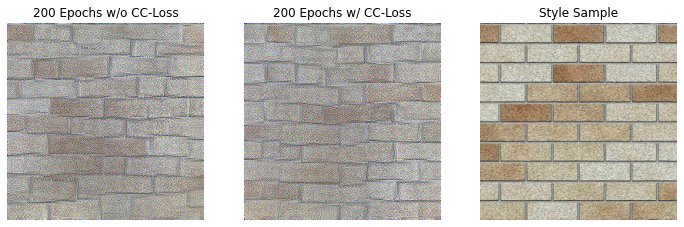

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].imshow(tf.keras.utils.array_to_img(wall200))
ax[0].set_title("200 Epochs w/o CC-Loss")
ax[1].imshow(tf.keras.utils.array_to_img(wall200cc))
ax[1].set_title("200 Epochs w/ CC-Loss")
ax[2].imshow(tf.keras.utils.array_to_img(wall_image[0]))
ax[2].set_title("Style Sample")

for axi in ax.ravel():
    axi.set_axis_off()

Crosscorrelation loss lead to some improvement and running the optimization loop for longer will improve the results.

Note how computationally expensive CC loss is: The runtime went up from 11min without CC-loss to 1:15h with CC-loss.  This is unsurprising given the loss for each of the 6 transformations applied is of similar complexity to the basic style loss.

## Example with Symmetry
Another example of long-range structure is symmetry.  Instead of the translation operators defined above, consider these symmetry operators which flip the image along its axes.

In [ ]:
def Sx(Fl):
    """Flip along y-axis for x-symmetry."""
    return tf.reverse(Fl, [1])

def Sy(Fl):
    """Flip along x-axis for y-symmetry."""
    return tf.reverse(Fl, [2])

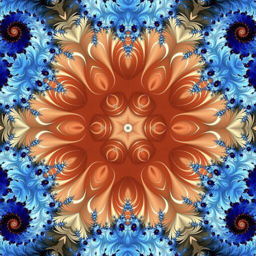

In [ ]:
!wget -q https://github.com/mdehling/neural-style-transfer/raw/main/img/fractal.jpeg
fractal_image = load_image("fractal.jpeg", target_size=(256,256))
show_image(fractal_image)

This fractal style sample has a clear symmetry to it and crosscorrelation loss helps carry it over to the generated image.  You may choose to only keep horizontal _or_ vertical symmetry by removing either of the symmetry operators below.  Unchanged this will reproduce both.

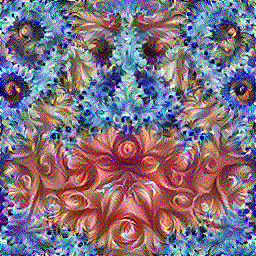

In [ ]:
# Runtime ca 15min on Colab!
optimizer = tf.keras.optimizers.Adam(0.3)
imgen = ImageGenerator([
        StyleLoss(fractal_image, style_model),
        VariationLoss(weight=1e-6),
        CrosscorrelationLoss(fractal_image, style_model,
            [ (id,Sx), (id,Sy) ])
    ], optimizer)
imgen(epochs=100)

I will let this run for longer since the results can look quite nice.

In [ ]:
# Runtime ca 1h on Colab!
imgen(epochs=400, show=False)

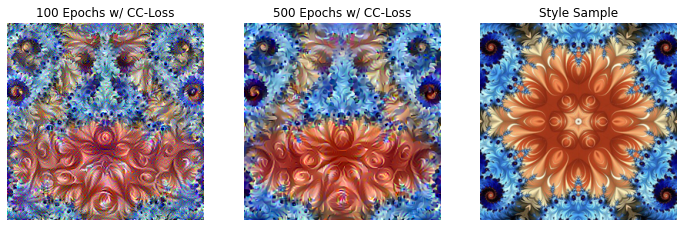

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].imshow(tf.keras.utils.array_to_img(imgen.images[100]))
ax[0].set_title("100 Epochs w/ CC-Loss")
ax[1].imshow(tf.keras.utils.array_to_img(imgen.images[500]))
ax[1].set_title("500 Epochs w/ CC-Loss")
ax[2].imshow(tf.keras.utils.array_to_img(fractal_image[0]))
ax[2].set_title("Style Sample")

for axi in ax.ravel():
    axi.set_axis_off()

It is important to note that the symmetry operators only help reproduce stylistic symmetry of the sample.  They do _not_ force symmetry in the generated image in cases where the sample is not symmetric!

# Neural Style Transfer
Neural style transfer was first introduced by Gatys et al in their article _A Neural Algorithm of Artistic Style_ [2].  In a way it is a simple extension of texture synthesis:  It was known for some time that the deeper layers of a CNN do a good job of capturing the content of an image.  Gatys proposed to simply measure the content loss by the mean squared distance between the outputs of a chosen layer for the content image and the generated one.

## VGG19 Content Model
The content model's output is simply the output of a certain deep layer of the VGG19 CNN pre-trained on the ImageNet dataset.  It is possible to add more layers, but this has little effect.

In [ ]:
class VGG19_Content(tf.keras.Model):

    def __init__(self):
        base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
        base_model.trainable = False

        content_layers = [
            "block5_conv2"
        ]

        outputs = [ base_model.get_layer(name).output for name in content_layers ]

        super().__init__(inputs=base_model.input, outputs=outputs)

    def call(self, inputs, **kwargs):
        inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        
        return super().call(inputs, **kwargs)

In [ ]:
content_model = VGG19_Content()

## Content Loss
Let $\hat{F}$ be the content model output for the provided content image and $F$ that for the generated image.  The content loss is the mean squared error between the outputs:
$$ \mathcal{L}_C = \frac{1}{2N_lM_l} \sum_{r,s} \big( F_{rs} - \hat{F}_{rs} \big)^2 \quad. $$

(Gatys chose to work with the total squared error instead, i.e., without normalizing by $N_l M_l$.)

In [ ]:
class ContentLoss:

    def __init__(self, content_image, content_model, weight=1e-2):
        self.content_image = content_image
        self.content_model = content_model
        self.weight = weight

        self.image_targets = self.content_model(self.content_image)

    def __call__(self, image):
        image_features = self.content_model(image)

        layer_losses = [
            tf.reduce_mean(tf.square(feature - target)) / 2
            for feature, target in zip(image_features, self.image_targets)
        ]
        
        return self.weight * tf.add_n(layer_losses) / len(layer_losses)

## Example of Style Transfer
Consider the following sunflower image.  I will try to transfer the style of the above fractal image onto it.

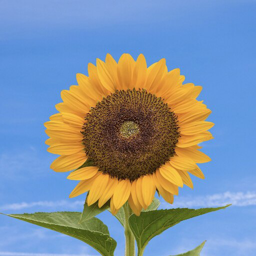

In [ ]:
!wget -q https://github.com/mdehling/neural-style-transfer/raw/main/img/sunflower.jpeg
sunflower_image = load_image("sunflower.jpeg", target_size=(256,256))
show_image(sunflower_image)

Choosing the "right" weights for the losses takes some experimenting and is, of course, a matter of taste.

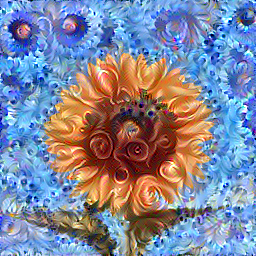

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.1)
imgen = ImageGenerator([
        StyleLoss(fractal_image, style_model, weight=1.0),
        ContentLoss(sunflower_image, content_model, weight=1e-3),
        VariationLoss(weight=1e-7)
    ], optimizer, initial=sunflower_image)
imgen(epochs=100)
sunflower_fractal = imgen.image

I quite like the image produced here, but some things could still be improved.  One issue is that the colors don't exactly match those of the content image:  The sunflower is a little too orange and the sky's blue is a little too dark.  This is because the colors come (mostly) from the style image.  Taking that into account, the match here is actually surprisingly good!

## Color Matching
Gatys et al proposed two ways of preserving the colors of the content image during style transfer in their article _Preserving Color in Neural Artistic Style Transfer_ [5].  The first approach is to apply style transfer to the luminance channel of the images only and then recombining the resulting image with the chrominance channels of the content image.  The second option is to modify the style image to match the color histogram of the content image before applying neural style transfer.

### Luminance-Only Transfer
The matrices below convert RGB color information to YCbCr and vice versa.  In the original article a YIQ color model was used.  The results are the same since we don't manipulate the chrominance plane in any way.

In [ ]:
A_RGB2YCbCr = tf.constant([[ 0.2126,  0.7152,  0.0722],
                           [-0.1146, -0.3854,  0.5000],
                           [ 0.5000, -0.4542, -0.0458]], dtype=tf.float32)
A_YCbCr2RGB = tf.constant([[1.0,  0.0000,  1.5748],
                           [1.0, -0.1873, -0.4681],
                           [1.0,  1.8556,  0.0000]], dtype=tf.float32)

In [ ]:
def rgb_to_y_cc(image_rgb):
    """
    Convert a 3-channel RGB image tensor to a 1-channel luminance (Y) and a
    2-channel chrominance tensor.
    """
    image_ycc = tf.einsum('dc,byxc->byxd', A_RGB2YCbCr, image_rgb)
    return image_ycc[:,:,:,0:1], image_ycc[:,:,:,1:3]

def y_cc_to_rgb(image_y, image_cc=None):
    """
    Combine a 1-channel luminance and (optionally) a 2-channel chrominance
    tensor into a 3-channel RGB image tensor.
    """
    if image_cc is None:
        zeros = tf.zeros(tf.shape(image_y), dtype=tf.float32)
        image_cc = tf.concat([zeros, zeros], axis=-1)
    image_ycc = tf.concat([image_y, image_cc], axis=-1)

    return tf.einsum('dc,byxc->byxd', A_YCbCr2RGB, image_ycc)

Compute luminance and chrominance tensors for the style and content images.  Convert the luminance (with zero chrominance) back to RGB for use with the content/style models: the VGG19 model we use expects 3-channel inputs.

In [ ]:
sunflower_y, sunflower_cc = rgb_to_y_cc(sunflower_image)
sunflower_y_as_rgb = y_cc_to_rgb(sunflower_y)
fractal_y, fractal_cc = rgb_to_y_cc(fractal_image)
fractal_y_as_rgb = y_cc_to_rgb(fractal_y)

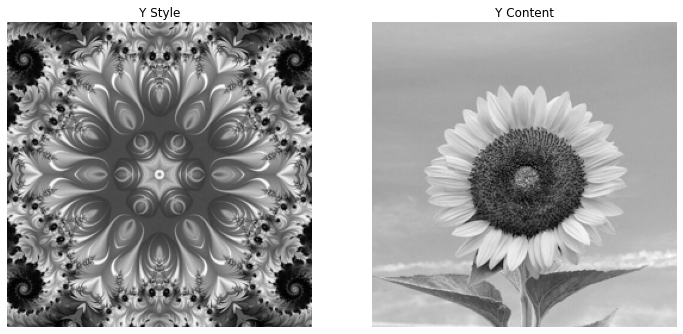

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].imshow(tf.keras.utils.array_to_img(fractal_y_as_rgb[0]))
ax[0].set_title("Y Style")
ax[1].imshow(tf.keras.utils.array_to_img(sunflower_y_as_rgb[0]))
ax[1].set_title("Y Content")

for axi in ax.ravel():
    axi.set_axis_off()

Now apply neural style transfer to the luminance-only style/content image pair.

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.1)
imgen = ImageGenerator([
        StyleLoss(fractal_y_as_rgb, style_model, weight=1.0),
        ContentLoss(sunflower_y_as_rgb, content_model, weight=1e-3),
        VariationLoss(weight=1e-7)
    ], optimizer, initial=sunflower_y_as_rgb)
imgen(epochs=100, show=False)

Combine the output luminance channel with the content image's chrominance channels to produce the final result.

In [ ]:
sunflower_fractal_y, _ = rgb_to_y_cc(imgen.image)
sunflower_fractal_y_as_rgb = y_cc_to_rgb(sunflower_fractal_y)
sunflower_fractal_rgb = y_cc_to_rgb(sunflower_fractal_y, sunflower_cc)

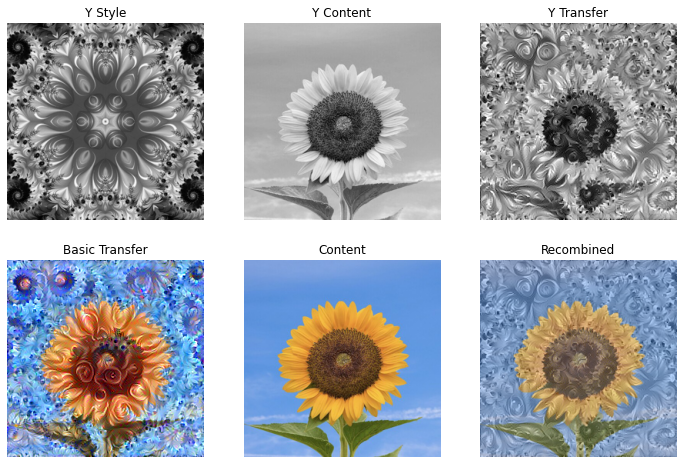

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))

ax[0,0].imshow(tf.keras.utils.array_to_img(fractal_y_as_rgb[0]))
ax[0,0].set_title("Y Style")
ax[0,1].imshow(tf.keras.utils.array_to_img(sunflower_y_as_rgb[0]))
ax[0,1].set_title("Y Content")
ax[0,2].imshow(tf.keras.utils.array_to_img(sunflower_fractal_y_as_rgb[0]))
ax[0,2].set_title("Y Transfer")

ax[1,0].imshow(tf.keras.utils.array_to_img(sunflower_fractal[0]))
ax[1,0].set_title("Basic Transfer")
ax[1,1].imshow(tf.keras.utils.array_to_img(sunflower_image[0]))
ax[1,1].set_title("Content")
ax[1,2].imshow(tf.keras.utils.array_to_img(sunflower_fractal_rgb[0]))
ax[1,2].set_title("Recombined")

for axi in ax.ravel():
    axi.set_axis_off()

Note that the luminance and chrominance channels don't form a perfect match.  This is a systemic problem with the luminance-transfer approach:  By construction, the colors match those of the content image but don't lign up perfectly with the transferred style/texture.

### Color Histogram Matching
The idea behind color histogram matching is to replace the style image $S$ by a modified style image $S'$ whose color histogram matches that of the content image $C$ in some sense.  Once that is done, one can apply neural style transfer to the pair $(S',C)$ instead of $(S,C)$ in the hope of better results.

Denote by $X_{ij}$ the pixels of an image as 3-vectors $(R,G,B)^T$. The approach here is to find and apply a pixelwise affine transformation $(A,b)$ to the style image $S$ such that the modified style image $S'$ with pixels $X_{S',ij} = A X_{S,ij} + b$ has mean and covariance matching that of the content image, i.e.,
$$ \mu_{S'} = \mu_C \quad\text{and}\quad \Sigma_{S'} = \Sigma_C \quad.$$
To find such an affine transformation, it is enough to choose a 3-by-3 matrix $A$ satisfying $A \Sigma_S A^T = \Sigma_C$ and let $b = \mu_C - A\mu_S$.

A solution can be obtained from the eigenvalue decomposition $\Sigma = U \Lambda U^T$ of the covariance matrices. Denote by $\Sigma^\frac{1}{2} = U \Lambda^\frac{1}{2} U^T$ and  $\Sigma^{-\frac{1}{2}} = U \Lambda^{-\frac{1}{2}} U^T$ the (inverse) square root of a covariance matrix.  Then
$$ A = \Sigma_C^{\frac{1}{2}} \Sigma_S^{-\frac{1}{2}} \quad\text{and}\quad b = \mu_C - A\mu_S $$
satisfy the above equations.  A proof of this statement can be found in Appendix B of Hertzmann's PhD thesis _Algorithms for Rendering in Artistic Styles_ [6].

Recall that the mean $\mu$ and covariance matrix $\Sigma$ are defined as
$$ \mu = \sum_{i,j} \frac{X_{ij}}{N} \quad\text{and}\quad
\Sigma = \sum_{i,j} \frac{(X_{ij}-\mu)(X_{ij}-\mu)^T}{N} \quad,$$
where $N$ denotes the number of pixels of the image.

In [ ]:
def image_statistics(X):
    """Compute mean and covariance matrix."""
    batches, height, width, channels = tf.shape(X)
    N = height * width

    mu = tf.einsum('bijc->bc', X) / tf.cast(N, tf.float32)

    mu_ = tf.reshape(mu, (batches,1,1,channels))
    Sigma = tf.einsum('bijc,bijd->bcd', X-mu_, X-mu_) / tf.cast(N, tf.float32)

    return mu, Sigma

In [ ]:
def eigen_decomposition(M):
    """
    Given a real symmetric matrix M, return its orthogonal eigenvalue
    decomposition (U, Lambda).
    """
    L, U = tf.linalg.eigh(M)
    Lambda = tf.linalg.diag(L)

    return U, Lambda

The following function matches the color histogram of the style image to that of the content image.

In [ ]:
def match_histogram(style_image, content_image):
    """
    Returns a modified style_image with mean and covariance matching those of
    the content_image.
    """
    batches, _, _, channels = tf.shape(style_image)
    
    mu_c, Sigma_c = image_statistics(content_image)
    U_c, Lambda_c = eigen_decomposition(Sigma_c)

    mu_s, Sigma_s = image_statistics(style_image)
    U_s, Lambda_s = eigen_decomposition(Sigma_s)

    sqrt_Sigma_c = U_c @ tf.sqrt(Lambda_c) @ tf.transpose(U_c, perm=[0,2,1])
    sqrti_Sigma_s = U_s @ tf.linalg.inv(tf.sqrt(Lambda_s)) @ tf.transpose(U_s, perm=[0,2,1])

    A = sqrt_Sigma_c @ sqrti_Sigma_s
    b = mu_c - tf.linalg.matvec(A, mu_s)

    # Use broadcasting to apply the affine transformation to each pixel
    A = tf.reshape(A, (batches,1,1,channels,channels))
    b = tf.reshape(b, (batches,1,1,channels))

    matched_style_image = tf.linalg.matvec(A, style_image) + b

    return tf.clip_by_value(matched_style_image, 0.0, 255.0)

This constructs the modified style image for the fractal/sunflower example.

In [ ]:
matched_fractal_image = match_histogram(fractal_image, sunflower_image)

Finally use neural style transfer on the color-matched fractal and the sunflower image.

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.1)
imgen = ImageGenerator([
        StyleLoss(matched_fractal_image, style_model, weight=1.0),
        ContentLoss(sunflower_image, content_model, weight=1e-3),
        VariationLoss(weight=1e-7)
    ], optimizer, initial=sunflower_image)
imgen(epochs=100, show=False)
matched_sunflower_fractal = imgen.image

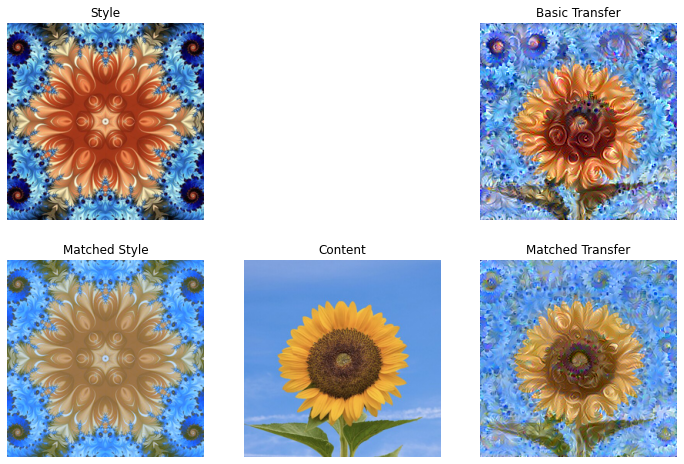

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))

ax[0,0].imshow(tf.keras.utils.array_to_img(fractal_image[0]))
ax[0,0].set_title("Style")
ax[0,2].imshow(tf.keras.utils.array_to_img(sunflower_fractal[0]))
ax[0,2].set_title("Basic Transfer")

ax[1,0].imshow(tf.keras.utils.array_to_img(matched_fractal_image[0]))
ax[1,0].set_title("Matched Style")
ax[1,1].imshow(tf.keras.utils.array_to_img(sunflower_image[0]))
ax[1,1].set_title("Content")
ax[1,2].imshow(tf.keras.utils.array_to_img(matched_sunflower_fractal[0]))
ax[1,2].set_title("Matched Transfer")

for axi in ax.ravel():
    axi.set_axis_off()

The result matches the colors of the content image much better, _and_ the colors are aligned with the structure!

### A Comparison
And here is a side-by-side comparison of the transferred images produced above  with the content image.

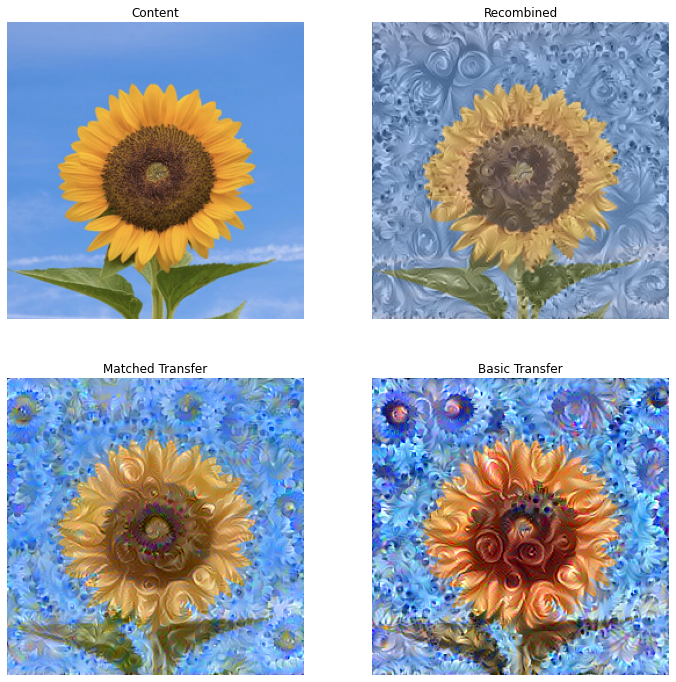

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

ax[0,0].imshow(tf.keras.utils.array_to_img(sunflower_image[0]))
ax[0,0].set_title("Content")
ax[0,1].imshow(tf.keras.utils.array_to_img(sunflower_fractal_rgb[0]))
ax[0,1].set_title("Recombined")
ax[1,0].imshow(tf.keras.utils.array_to_img(matched_sunflower_fractal[0]))
ax[1,0].set_title("Matched Transfer")
ax[1,1].imshow(tf.keras.utils.array_to_img(sunflower_fractal[0]))
ax[1,1].set_title("Basic Transfer")

for axi in ax.ravel():
    axi.set_axis_off()

# References
1. Gatys, Ecker, Bethge - _Texture Synthesis Using Convolutional Neural Networks_, 2015.
2. Gatys, Ecker, Bethge - _A Neural Algorithm of Artistic Style_, 2015.
3. Berger, Memisevic - _Incorporating Long-Range Consistency in CNN-Based Texture Generation_, 2017.
4. Gatys, Ecker, Bethge, Hertzmann, Shechtman - _Controlling Perceptual Factors in Neural Style Transfer_, 2017.
5. Gatys, Bethge, Hertzmann, Shechtman - _Preserving Color in Neural Artistic Style Transfer_, 2016.
6. Hertzmann - _Algorithms for Rendering in Artistic Styles_, 2001.